In [1]:
import os

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Activation,
    Conv2D,
    BatchNormalization,
    AveragePooling2D,
    Flatten,
    add
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## util functions

In [2]:
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    print('Learning rate: ', lr)
    
    return lr


def dense_block(inputs,
                n_layers=16,
                growth_rate=12):
    
    x = inputs
    
    for i in range(n_layers):
        # bottleneck layer
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4*growth_rate,
                   kernel_size=1,
                   strides=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        
        # dense layer
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   strides=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        
        x = K.concatenate([x, y])
        
    return x


def transition_layer(inputs,
                     theta=0.5):
    
    x = inputs
    
    y = BatchNormalization()(x)
    y = Activation('relu')(y)
    y = Conv2D(int(x.shape[-1]*theta),
               kernel_size=1,
               strides=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    y = AveragePooling2D(pool_size=2,
                         strides=2)(y)
    
    return y

## load data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize data.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

num_classes = len(np.unique(y_train))

# one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## model configuration

In [4]:
input_shape = x_train.shape[1:]
batch_size = 64
epochs = 100

L = 100
growth_rate = 12
n_dense_block = 3
n_transition_layer = n_dense_block - 1
theta = 0.5

# 1st 2 for input conv, and output fc layer
# 2nd 2 for bottleneck, dense layer in each dense block
n_layer_in_dense_block = int((L-2-n_transition_layer) / (2*n_dense_block))

In [5]:
inputs = Input(shape=input_shape)

In [6]:
# initialize with 3x3 conv
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(filters=2*growth_rate,
           kernel_size=3,
           strides=1,
           padding='same',
           kernel_initializer='he_normal')(x)

In [7]:
# add dense blocks
dense1 = dense_block(x, growth_rate, n_layer_in_dense_block)
trans1 = transition_layer(dense1, theta)

dense2 = dense_block(trans1, growth_rate, n_layer_in_dense_block)
trans2 = transition_layer(dense2, theta)

dense3 = dense_block(trans2, growth_rate, n_layer_in_dense_block)

In [8]:
# 8x8 pool
x = AveragePooling2D(pool_size=8)(dense3)

# fc-softmax
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

In [9]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


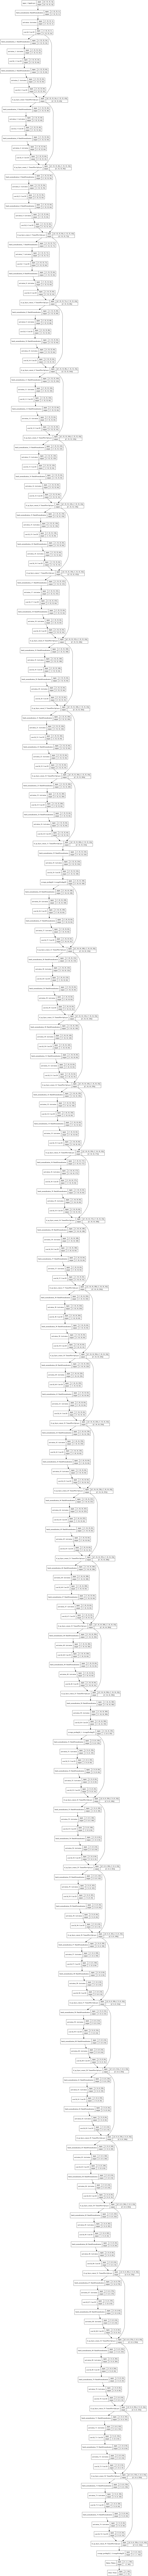

In [10]:
plot_model(model, to_file='../figures/densenet.png', show_shapes=True)

In [11]:
# save_dir = '../models/densenet'
# os.makedirs(save_dir, exist_ok=True)

In [12]:
# # prepare callbacks for model saving and for learning rate adjustment.
# file_path = save_dir
# checkpoint = ModelCheckpoint(filepath=file_path,
#                              monitor='val_accuracy',
#                              verbose=1,
#                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]

* train model with data-augmentation

In [13]:
# # this will do preprocessing and realtime data augmentation:
# datagen = ImageDataGenerator(
#     # set input mean to 0 over the dataset
#     featurewise_center=False,
#     # set each sample mean to 0
#     samplewise_center=False,
#     # divide inputs by std of dataset
#     featurewise_std_normalization=False,
#     # divide each input by its std
#     samplewise_std_normalization=False,
#     # apply ZCA whitening
#     zca_whitening=False,
#     # randomly rotate images in the range (deg 0 to 180)
#     rotation_range=0,
#     # randomly shift images horizontally
#     width_shift_range=0.1,
#     # randomly shift images vertically
#     height_shift_range=0.1,
#     # randomly flip images
#     horizontal_flip=True,
#     # randomly flip images
#     vertical_flip=False
# )

In [14]:
# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(x_train)

In [15]:
# # fit the model on the batches generated by datagen.flow().
# model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                     validation_data=(x_test, y_test),
#                     epochs=epochs, verbose=1,
#                     steps_per_epoch=len(x_train)//batch_size,
#                     callbacks=callbacks)

In [16]:
import tensorflow as tf

In [17]:
model = tf.keras.models.load_model('../models/densenet')

In [ ]:
loss, acc = model.evaluate(x_test, y_test, batch_size, verbose=2)

In [21]:
print('accuracy: {:01f}'.format(acc*100))

accuracy: 87.730002


## see src/resnet_v1.py

## compare resnet result with
* https://github.com/youjin2/ds029/blob/master/notebooks/01_cnn_cifar10.ipynb